Stock Market Prediction And Forecasting Using Stacked LSTM. Based on the tutorial given on this link(https://www.youtube.com/watch?v=H6du_pfuznE)


Import Libraries

In [13]:
import pandas as pd
import numpy as np 
import tensorflow as tf

In [14]:
import pandas_datareader as pdr
key='37689f78f60a06fca6b32e11ff70f9d2c10937ec'

In [15]:
df = pdr.get_data_tiingo('AAPL', api_key=key) #retrieve data in the form of a dataframe


In [16]:
df.to_csv('AAPL.csv') #save df to csv file

In [17]:
df = pd.read_csv('AAPL.csv') #load csv file

In [18]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-07-18 00:00:00+00:00,99.83,100.13,98.600,98.70,36493867,23.311648,23.381702,23.024426,23.047777,145975468,0.0,1.0
1,AAPL,2016-07-19 00:00:00+00:00,99.87,100.00,99.340,99.56,23779924,23.320988,23.351345,23.197226,23.248599,95119696,0.0,1.0
2,AAPL,2016-07-20 00:00:00+00:00,99.96,100.46,99.735,100.00,26275968,23.342004,23.458761,23.289464,23.351345,105103872,0.0,1.0
3,AAPL,2016-07-21 00:00:00+00:00,99.43,101.00,99.130,99.83,32702028,23.218242,23.584858,23.148188,23.311648,130808112,0.0,1.0
4,AAPL,2016-07-22 00:00:00+00:00,98.66,99.30,98.310,99.26,28313669,23.038437,23.187885,22.956707,23.178545,113254676,0.0,1.0


In [19]:
df.tail() #viewing the tail to determine the latest date. We will predict the values of the stock based on the close column

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2021-07-08 00:00:00+00:00,143.24,144.06,140.6650,141.58,105575458,143.24,144.06,140.6650,141.58,105575458,0.0,1.0
1253,AAPL,2021-07-09 00:00:00+00:00,145.11,145.65,142.6522,142.75,99890800,145.11,145.65,142.6522,142.75,99890800,0.0,1.0
1254,AAPL,2021-07-12 00:00:00+00:00,144.50,146.32,144.0000,146.21,76299719,144.50,146.32,144.0000,146.21,76299719,0.0,1.0
1255,AAPL,2021-07-13 00:00:00+00:00,145.64,147.46,143.6300,144.03,100827099,145.64,147.46,143.6300,144.03,100827099,0.0,1.0
1256,AAPL,2021-07-14 00:00:00+00:00,149.15,149.57,147.6800,148.10,127050785,149.15,149.57,147.6800,148.10,127050785,0.0,1.0


In [20]:
df1=df.reset_index()['close']

In [21]:
df1

0        99.83
1        99.87
2        99.96
3        99.43
4        98.66
         ...  
1252    143.24
1253    145.11
1254    144.50
1255    145.64
1256    149.15
Name: close, Length: 1257, dtype: float64

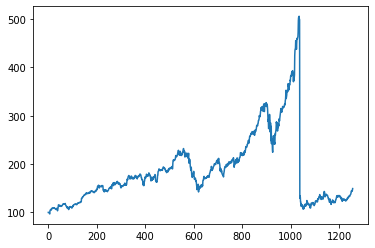

In [22]:
import matplotlib.pyplot as plt #plotting stock price over the past 5 years
plt.plot(df1)

Applying min max scaler to account for LSTMs sensitivity to the scale of data 

In [23]:
df1

0        99.83
1        99.87
2        99.96
3        99.43
4        98.66
         ...  
1252    143.24
1253    145.11
1254    144.50
1255    145.64
1256    149.15
Name: close, Length: 1257, dtype: float64

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1)) #converting data into array

In [25]:
print(df1)

[[0.00771824]
 [0.00781593]
 [0.00803576]
 ...
 [0.1168238 ]
 [0.11960823]
 [0.12818133]]


In [26]:
#splitting dataset into train and test . The data for timeseries is divided based on date and not randomly, as the stock prices movements change with the date and are therefore related to it
training_size=int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df),:1]

In [27]:
training_size,test_size

(817, 440)

In [28]:
train_data

array([[0.00771824],
       [0.00781593],
       [0.00803576],
       [0.00674124],
       [0.00486053],
       [0.00163646],
       [0.        ],
       [0.01533877],
       [0.01873382],
       [0.0184163 ],
       [0.02291046],
       [0.01907577],
       [0.02227541],
       [0.02247081],
       [0.0264032 ],
       [0.02857701],
       [0.0296517 ],
       [0.02767329],
       [0.02750232],
       [0.02811294],
       [0.03128816],
       [0.03104392],
       [0.03065312],
       [0.03031117],
       [0.03099507],
       [0.02891896],
       [0.0297494 ],
       [0.02774657],
       [0.02662303],
       [0.02508427],
       [0.02479117],
       [0.02278833],
       [0.02303258],
       [0.02457134],
       [0.02701382],
       [0.02694055],
       [0.02855259],
       [0.02161594],
       [0.01577842],
       [0.02142055],
       [0.02755117],
       [0.03688144],
       [0.04616286],
       [0.04457525],
       [0.04130233],
       [0.04127791],
       [0.04122906],
       [0.043

In [29]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
   dataX, dataY = [],[]
   for i in range(len(dataset)-time_step-1):
     a=dataset[i:(i+time_step),0]
     dataX.append(a)
     dataY.append(dataset[i+time_step, 0])
   return numpy.array(dataX), numpy.array(dataY)


In [33]:
#reshape into X=t, t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data,time_step)

In [34]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [35]:
print(X_test.shape), print(ytest.shape)

(339, 100)
(339,)


(None, None)

In [36]:
#reshape input to [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] ,1)

In [37]:
# create Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [38]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train,y_train,validation_data=(X_test,ytest), epochs=100,batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 8s 271ms/step - loss: 0.0090 - val_loss: 0.0367
Epoch 2/100
12/12 [==============================] - 2s 171ms/step - loss: 0.0023 - val_loss: 0.0240
Epoch 3/100
12/12 [==============================] - 2s 172ms/step - loss: 0.0012 - val_loss: 0.0234
Epoch 4/100
12/12 [==============================] - 2s 176ms/step - loss: 7.2377e-04 - val_loss: 0.0201
Epoch 5/100
12/12 [==============================] - 2s 171ms/step - loss: 4.6359e-04 - val_loss: 0.0196
Epoch 6/100
12/12 [==============================] - 2s 171ms/step - loss: 4.1509e-04 - val_loss: 0.0204
Epoch 7/100
12/12 [==============================] - 2s 173ms/step - loss: 3.9186e-04 - val_loss: 0.0195
Epoch 8/100
12/12 [==============================] - 2s 174ms/step - loss: 3.8176e-04 - val_loss: 0.0190
Epoch 9/100
12/12 [==============================] - 2s 174ms/step - loss: 3.6902e-04 - val_loss: 0.0184
Epoch 10/100
12/12 [==============================] - 2s 170ms/step

In [41]:

tf.__version__

'2.5.0'

In [42]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


In [43]:
#transform data to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [46]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

176.16156520334775

In [47]:
## Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

208.04709905273623

In [48]:
## Test data RMSE
math.sqrt(mean_squared_error(ytest, test_predict))

208.04709905273623

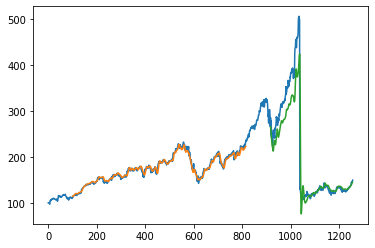

In [49]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [50]:
len(test_data)

440

In [51]:
x_input = test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [52]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [53]:
temp_input

[0.07163792682331105,
 0.07129597967856965,
 0.07005031507986909,
 0.05940110400078158,
 0.060060573494211345,
 0.07600996531678961,
 0.0694885447706512,
 0.06201455717844756,
 0.05730057154022761,
 0.060451370231058565,
 0.048092423428264364,
 0.05963313956328464,
 0.056934199599433355,
 0.061770309217917985,
 0.0594988031849934,
 0.06672854281666746,
 0.07058766059303401,
 0.06860925211274488,
 0.05827756338234574,
 0.05695862439548627,
 0.06526305505349028,
 0.06318694738898933,
 0.057202872356015844,
 0.0584241121586635,
 0.05993844951394656,
 0.060378095842899715,
 0.05673880123100972,
 0.06223438034292417,
 0.06431048800742512,
 0.07139367886278153,
 0.072150847540423,
 0.0762786380733721,
 0.08228713790239855,
 0.0887230716623516,
 0.08443651995505841,
 0.09222802989595041,
 0.08636607884324166,
 0.09239900346832103,
 0.09156856040252065,
 0.09322944653412146,
 0.0890039568169606,
 0.08995652386302572,
 0.0861462556787651,
 0.09195935713936787,
 0.092936348981486,
 0.09213033071

In [58]:
# predictions for the next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

  if(len(temp_input)>100):
    #print(temp_input)
    x_input=np.array(temp_input[1:])
    print('{} day input {}'.format(i, x_input))
    x_input=x_input.reshape(1,-1)
    x_input= x_input.reshape((1,n_steps, 1))
    #print(x_input)
    yhat = model.predict(x_input, verbose=0)
    print('{} day output {}'.format(i, yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    #print(temp_input)
    lst_output.extend(yhat.tolist())
    i=i+1
  else:
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i=i+1

print(lst_output)


[0.12173592]
101
1 day input [0.07129598 0.07005032 0.0594011  0.06006057 0.07600997 0.06948854
 0.06201456 0.05730057 0.06045137 0.04809242 0.05963314 0.0569342
 0.06177031 0.0594988  0.06672854 0.07058766 0.06860925 0.05827756
 0.05695862 0.06526306 0.06318695 0.05720287 0.05842411 0.05993845
 0.0603781  0.0567388  0.06223438 0.06431049 0.07139368 0.07215085
 0.07627864 0.08228714 0.08872307 0.08443652 0.09222803 0.08636608
 0.092399   0.09156856 0.09322945 0.08900396 0.08995652 0.08614626
 0.09195936 0.09293635 0.09213033 0.09015192 0.08990767 0.08497387
 0.08761174 0.07615651 0.07676713 0.0807728  0.08192077 0.07371403
 0.0714181  0.06374872 0.06912217 0.07517952 0.0722974  0.06882908
 0.06843828 0.07483758 0.07024571 0.07432465 0.07383616 0.07371403
 0.06987934 0.06824288 0.06743686 0.069342   0.06562943 0.07136925
 0.07139368 0.07344536 0.07439793 0.0719066  0.07493527 0.08258024
 0.08052855 0.08177422 0.08577988 0.08253139 0.08702555 0.09112891
 0.09044502 0.0897367  0.08900396 

In [59]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)


In [60]:
import matplotlib.pyplot as plt

In [61]:
len(df1)

1257

NameError: ignored

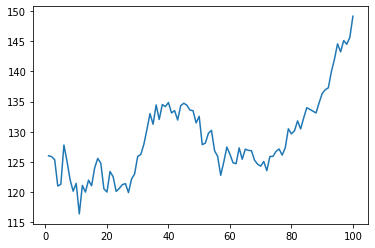

In [62]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler, inverse_transform(lst_output))

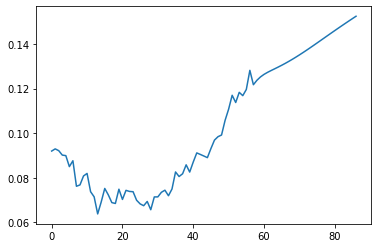

In [63]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [64]:
df3=scaler.inverse_transform(df3).tolist()

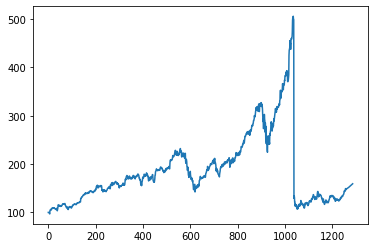

In [65]:
plt.plot(df3)